# Installation

In [1]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


# Import Libraries

In [5]:
import os
import cv2
import numpy as np
from sklearn.utils import shuffle
from sklearn import model_selection
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import  CategoricalCrossentropy
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Activation, Flatten, Dense, Dropout, Convolution2D, MaxPooling2D, GlobalAveragePooling2D

In [6]:
main_directory = 'dataset'

In [7]:
class_map = {
    "rock": 0,
    "paper": 1,
    "scissors": 2,
    "lizard": 3,
    "spock": 4,
    "nothing": 5
}

# Dataset information:
- 9000 images which consist of 6 categories (each category has 1500 images)
- image sizes: 300x300 and 400x380, will be resized to 300x300
<br/><br/> More info on wiki page

# Load data
Resize images to 300x300 and change color to gray.

In [8]:
dataset = []
for directory in os.listdir(main_directory):
    path = os.path.join(main_directory, directory)
    if not os.path.isdir(path):
        continue
    for item in os.listdir(path):
        image = cv2.imread(os.path.join(path, item))
        image = cv2.resize(image, (300,300))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        dataset.append([image, directory])

# Show Examples

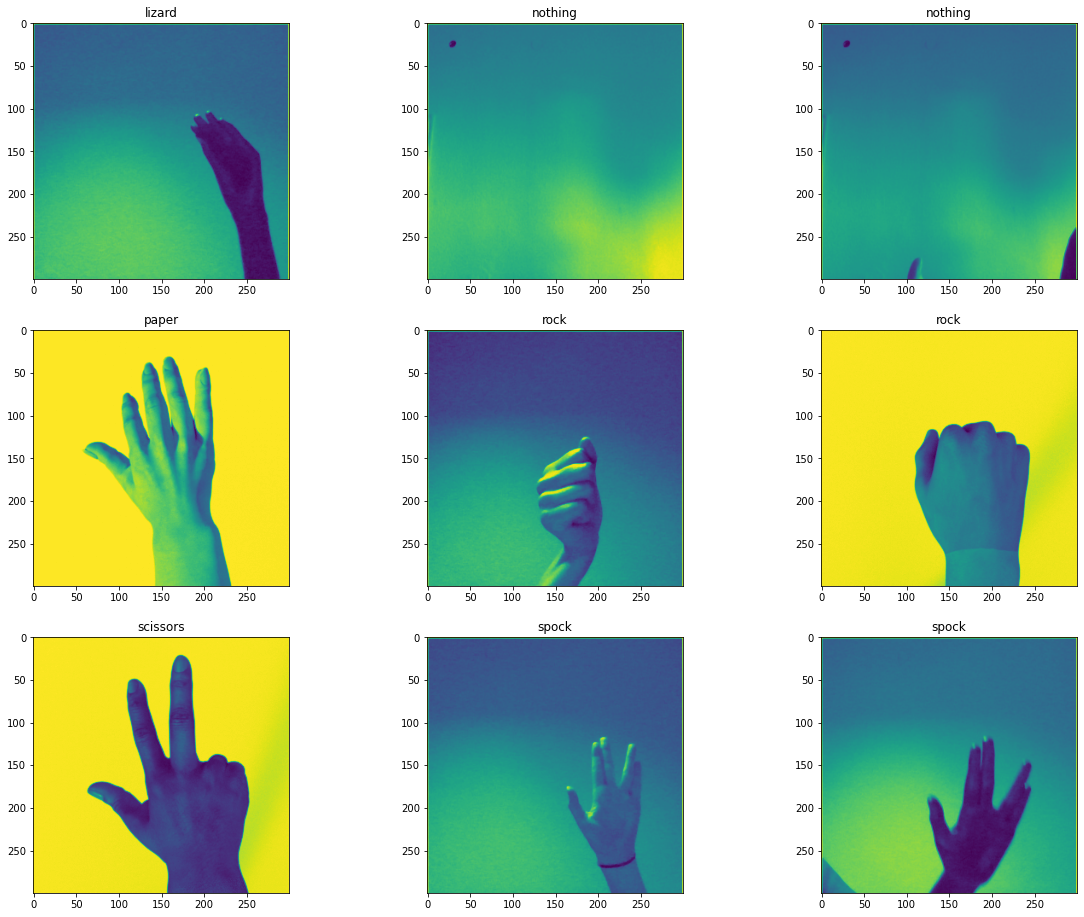

In [10]:
fig = plt.figure(figsize=(20,16))
for i in range(1, 10):
        fig.add_subplot(3, 3, i)
        image = dataset[i*999][0]
        plt.title(dataset[i*999][1])
        plt.imshow(image)
plt.show()

In [ ]:
data, labels = zip(*dataset)
target = []
for label in labels:
    target.append(class_map[label])

In [ ]:
data = shuffle(data, random_state = 0)

In [ ]:
x_train_val, x_test, y_train_val, y_test = model_selection.train_test_split(data, target, test_size = 0.33, \
                                                                            stratify = target, random_state = 0)

In [ ]:
x_train, x_val, y_train, y_val = model_selection.train_test_split(x_train_val, y_train_val, test_size = 0.2, \
                                                                            stratify = y_train_val, random_state = 0)

In [ ]:
x_train = np.array(x_train).astype('float32') / 255
x_val = np.array(x_val).astype('float32') / 255
x_test = np.array(x_test).astype('float32') / 255

In [ ]:
num_of_classes = len(class_map)
y_train = utils.to_categorical(y_train, num_of_classes)
y_val = utils.to_categorical(y_val, num_of_classes)
y_test = utils.to_categorical(y_test, num_of_classes)

In [ ]:
x_train = x_train.reshape(x_train.shape[0], 300, 300, 1)
x_val = x_val.reshape(x_val.shape[0], 300, 300, 1)
x_test = x_test.reshape(x_test.shape[0], 300, 300, 1)

# Initial convolutional neural network

In [ ]:
model = Sequential([
    InputLayer(input_shape=(300,300,1)),
    Convolution2D(64, 3, activation='relu'),
    Convolution2D(32, 3, activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.5),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(6, activation='softmax')
])

In [ ]:
model.compile(optimizer='adam',
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, epochs=5, batch_size=32, verbose=1)

# Second convolutional neural network

In [ ]:
model2 = Sequential([
    InputLayer(input_shape=(300,300,1)),
    Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
    AveragePooling2D(pool_size=(2, 2)),
    Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')
])

In [ ]:
model2.compile(optimizer='adam',
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])


In [ ]:
history2=model2.fit(x_train, y_train, epochs=5, batch_size=32)

# Hyperparameter Tuning

In [ ]:
pip install -U keras_tuner

In [ ]:
from kerastuner.tuners import RandomSearch

def build_model(hp):
  model = Sequential()

  model.add(MaxPooling2D(6,3,input_shape=(300,300,1)))

  for i in range(hp.Int("Conv Layers", min_value=0, max_value=3)):
    model.add(Convolution2D(hp.Choice(f"layer_{i}_filters", [16,32,64]), 3, activation='relu'))
  
  model.add(MaxPooling2D(2,2))
  model.add(Dropout(0.5))
  model.add(Flatten())

  model.add(Dense(hp.Choice("Dense layer", [64, 128, 256, 512, 1024]), activation='relu'))

  model.add(Dense(6, activation='softmax'))

  model.compile(optimizer='adam',
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])
  
  return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=32,
)

tuner.search(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=32)